In [1]:
import cProfile
import os
import statistics as st
import plotly.graph_objects as go
import random as rd
import time
import pandas as pd
import math
from collections import defaultdict
import numpy as np
import itertools as it
import Utilities.experiment_utils as eu
import unit_test as ut
import Games.mnk as mnk
import Games.Carcassonne.Carcassonne as carc
#import Games.carcassonne_older as csn
import Agents.random as arand
import Agents.vanilla_mcts as mcts 
import Agents.siea_mcts as siea_mcts
import Agents.mcts_rave as rave_mcts
import Games.function_optimisation as fo
import Utilities.logs_management as lm
import Games.chess_64 as chess_64
import matplotlib.pyplot as plt


#cProfile.run("wins =  random_games(10000, base_gs)")
#ut.run()

In [21]:
lichess_db = pd.read_csv("Datasets/lichess_db_puzzle.csv")
#lichess_db.head()

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1811,75,95,4171,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,NaN
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...,d3d6 f8d8 d6d8 f6d8,1565,73,96,22589,advantage endgame short,https://lichess.org/F8M8OS71#53,NaN
2,0009B,r2qr1k1/b1p2ppp/pp4n1/P1P1p3/4P1n1/B2P2Pb/3NBP...,b6c5 e2g4 h3g4 d1g4,1124,75,86,543,advantage middlegame short,https://lichess.org/4MWQCxQ6/black#32,Kings_Pawn_Game Kings_Pawn_Game_Leonardis_Vari...
3,000Vc,8/8/4k1p1/2KpP2p/5PP1/8/8/8 w - - 0 53,g4h5 g6h5 f4f5 e6e5 f5f6 e5f6,1556,81,89,81,crushing endgame long pawnEndgame,https://lichess.org/l6AejDMO#105,NaN
4,000Zo,4r3/1k6/pp3r2/1b2P2p/3R1p2/P1R2P2/1P4PP/6K1 w ...,e5f6 e8e1 g1f2 e1f1,1458,74,93,482,endgame mate mateIn2 short,https://lichess.org/n8Ff742v#69,NaN


In [27]:
lichess_db.iloc[0]["Moves"].split(" ")#["FEN"]

['f2g3', 'e6e7', 'b2b1', 'b3c1', 'b1c1', 'h6c1']

In [1]:
import requests
response = requests.get('https://api.lorcana-api.com/strict/elsa')
if response.status_code == 200:
    print(response.content)
else:
    print('Request failed with status code:', response.status_code)
response = requests.get('https://api.lorcana-api.com/lists/names')
if response.status_code == 200:
    print(response.content)
else:
    print('Request failed with status code:', response.status_code)

b'{"snow_queen":{"traits":null,"set":"The First Chapter","lore-value":1,"color":"Amethyst","strength":2,"artist":"Nicholas Kole","willpower":3,"type":"character","flavor_text":"Recreated by magical ink, Elsa found herself in an unfamiliar new world. Fortunately, ice works the same way everywhere.","subtypes":["Dreamborn","Hero","Queen","Sorcerer"],"set-code":"TFC","abilities":[{"FREEZE":"Excert chosen opposing character."}],"inkable":true,"subtitle":"Snow Queen","image-urls":[{"small":"https://lorcana-api.com/images/elsa/snow_queen/small.png","no-art":"https://lorcana-api.com/images/elsa/snow_queen/no-art.png","large":"https://lorcana-api.com/images/elsa/snow_queen/large.png","art-crop":"https://lorcana-api.com/images/elsa/snow_queen/art-crop.png","medium":"https://lorcana-api.com/images/elsa/snow_queen/medium.png"}],"name":"Elsa","ink-cost":3}}'
b'[\n    "simba-protective_cub",\n    "white_rabbits_pocket_watch",\n    "lefou-instigator",\n    "mickey_mouse-steamboat_pilot",\n    "peter

In [ ]:
response = requests.get('https://api.lorcana-api.com/lists/names')
if response.status_code == 200:
    print(response.content)
else:
    response_string = str(response.content).split("\\n")
    names = []
    for raw_name in response_string:
        if "," in raw_name:
            #print(raw_name)
            name = raw_name.replace("\"", "")
            # replace \ with nothing
            name = name.replace("\\", "")
            name = name.replace(" ", "")
            name = name.replace(",", "")
            if name == "mr": name = "mr_smee"
            if name == "dr": name = "dr_facilier"
            print(name)

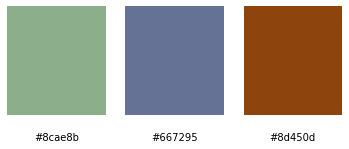

color_palette = ['#8cae8b', '#667295', '#8d450d']


In [9]:
color_palette = [ "#B10909" #red
                ,  "#5B8C5A"#green
                ,"#56638A" #blue-purple
                , "#EC7316" #orange
                ,  "#FC738C" ] #pink
color_palette = ["#5B8C5A"
                ,"#56638A"
                , "#EC7316"]
color_palette[2] = eu.color_rgb_to_hex(eu.darken_color(eu.color_hex_to_rgb(color_palette[2]), 0.4))
color_palette[0] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[0]), 0.3))
color_palette[1] = eu.color_rgb_to_hex(eu.brighten_color(eu.color_hex_to_rgb(color_palette[1]), 0.1))

eu.view_color_palette(color_palette)

print("color_palette = {}".format(color_palette))

In [ ]:
mcts_agent = mcts.MCTS_Player(max_iterations = 100)
siea_mcts_agent = siea_mcts.SIEA_MCTS_Player(max_iterations = 100)
#game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
#game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)])
game_state = carc.CarcassonneState()
#game_state = mnk.GameState(3,3,3)
game_state.set_initial_state()
#random_action = mcts_agent.choose_action(game_state)
#random_action = mcts_agent.choose_action(game_state)
#print("Max score", game_state.max_possible_score)
#print(random_action)
#print(len(game_state.available_actions))
#print(mcts_agent.view_mcts_tree())
gp1, gp2 = eu.play_match([mcts_agent, siea_mcts_agent], game_state, 2, os.path.join("Outputs", "test_match_carc2"), random_seed = 1)

In [12]:
#View tree on each iteration - STEP 1

mcts_agent = rave_mcts.MCTS_RAVE(max_iterations = 0, rollouts=10)
#mcts_agent = mcts.MCTS_Player(max_iterations = 0, rollouts=100)
#mcts_agent = siea_mcts.SIEA_MCTS_Player(max_iterations = 0)
#game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
#game_state = carc.CarcassonneState(initial_tile_quantities=[1 for _ in range(24)])
game_state = carc.CarcassonneState()
#game_state = mnk.GameState(3,3,3)
game_state = chess_64.GameState()
game_state.set_initial_state()
ut.test_game(game_state)
random_action = mcts_agent.choose_action(game_state)
#random_action = mcts_agent.choose_action(game_state)
#print("Max score", game_state.max_possible_score)
#print(random_action)
print(len(game_state.available_actions))
print(mcts_agent.view_mcts_tree())

Testing gameChess_fv:{63: 'r', 62: 'n', 61: 'b', 60: 'k', 59: 'q', 58: 'b', 57: 'n', 56: 'r', 55: 'p', 54: 'p', 53: 'p', 52: 'p', 51: 'p', 50: 'p', 49: 'p', 48: 'p', 15: 'P', 14: 'P', 13: 'P', 12: 'P', 11: 'P', 10: 'P', 9: 'P', 8: 'P', 7: 'R', 6: 'N', 5: 'B', 4: 'K', 3: 'Q', 2: 'B', 1: 'N', 0: 'R', 16: None, 17: None, 18: None, 19: None, 20: None, 21: None, 22: None, 23: None, 24: None, 25: None, 26: None, 27: None, 28: None, 29: None, 30: None, 31: None, 32: None, 33: None, 34: None, 35: None, 36: None, 37: None, 38: None, 39: None, 40: None, 41: None, 42: None, 43: None, 44: None, 45: None, 46: None, 47: None, 'player_turn': 0}
MCTS_RAVE : Random move returned
20

0:Decision_node, edge:None, visits:0, avg_rwd:nan, children:0, tree_policy_formula:None


In [11]:
#View tree on each iteration - STEP 2 - Iterate

#mcts iteration
node = mcts_agent.root_node

#Selection
node = mcts_agent.selection(node)

#Expansion
if node.can_be_expanded():
    node = mcts_agent.expansion(node)

#Simulation
reward = mcts_agent.simulation(node, mcts_agent.rollouts, mcts_agent.default_policy) 

#Backpropagation
mcts_agent.backpropagation(node, reward)

print(mcts_agent.view_mcts_tree())


0:Decision_node, edge:None, visits:8, avg_rwd:0.0875, children:8, tree_policy_formula:None
--1:Decision_node, edge:d2d3, visits:1, avg_rwd:0.2, children:0, amaf_visits:56, amaf_avg_rwd:0.0179, tree_policy_formula:2.15
--2:Decision_node, edge:c2c3, visits:1, avg_rwd:0.1, children:0, amaf_visits:60, amaf_avg_rwd:0.0667, tree_policy_formula:2.12
--3:Decision_node, edge:g1h3, visits:1, avg_rwd:0.2, children:0, amaf_visits:33, amaf_avg_rwd:0.0909, tree_policy_formula:2.19
--4:Decision_node, edge:e2e4, visits:1, avg_rwd:0, children:0, amaf_visits:22, amaf_avg_rwd:0.136, tree_policy_formula:2.11
--5:Decision_node, edge:g2g3, visits:1, avg_rwd:0.2, children:0, amaf_visits:26, amaf_avg_rwd:0.0385, tree_policy_formula:2.16
--6:Decision_node, edge:h2h4, visits:1, avg_rwd:0.1, children:0, amaf_visits:8, amaf_avg_rwd:0, tree_policy_formula:2.09
--7:Decision_node, edge:f2f4, visits:1, avg_rwd:0.1, children:0, amaf_visits:7, amaf_avg_rwd:-0.143, tree_policy_formula:2.03
--8:Decision_node, edge:g2g4,

In [5]:
TotalGames = 10
logs = True
random_seed = 1
if random_seed is not None: 
    rd.seed(random_seed)
    np.random.seed(random_seed)
else: 
    random_seed = rd.randint(0, 2**32)
    print("meh")
    rd.seed(random_seed)
    np.random.seed(random_seed)

game_state = carc.CarcassonneState(initial_tile_quantities=[1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,0,0,0,0,0,0,0])
#game_state = carc.CarcassonneState(initial_tile_quantities=[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0])
#game_state = mnk.GameState(m=3,n=3,k=3)
game_state.set_initial_state()
agent3 = arand.RandomPlayer()
agent2 = mcts.MCTS_Player(max_iterations=100)
players = [agent2, agent3]
games_count = 0
WinnerCount = {0:0, 1:0, "Draw":0}

all_action_logs = pd.DataFrame()
all_game_logs = pd.DataFrame()

ST = time.time()

for game in range(TotalGames):
    #gs = game_state.duplicate()
    gs = game_state.duplicate()

    #Set logs
    action_logs = pd.DataFrame()
    game_logs = pd.DataFrame()
    if logs:
        for p in players:
            p.logs = True

    #Play game
    safe_count = 0
    while not gs.is_terminal:
        start_time = time.time()
        action = players[gs.player_turn].choose_action(gs)
        #action = rd.choice(gs.available_actions)
        selection_time = time.time() - start_time

        #Update logs
        if logs:
            action_log = players[gs.player_turn].choose_action_logs #Assumes this log is single row
            action_log["game_index"] = games_count
            action_log["selection_time"] = selection_time
            action_log["returned_action"] = str(action)
            action_log["pg_player"] = str(players[gs.player_turn])
            action_logs = pd.concat([action_logs, action_log], ignore_index=True)
            game_logs = pd.concat([game_logs, gs.logs_data()], ignore_index=True)

        #safety check      
        safe_count += 1
        if safe_count > 1000: 
            print("Safe count exceeded")
            print(gs.logs_data())
            print("Last action:" + str(action))
            break
        assert safe_count < 1000, "Safe count exceeded"

        #Make action
        gs.make_action(action)

    if logs:
        #Final logs by action
        final_logs_by_action = pd.concat([action_logs, game_logs], axis=1)


        #Final logs by game
        final_logs_by_game_dict = {}
        for i, player in enumerate(players):
            final_logs_by_game_dict["Player_" + str(i)] = str(player)
        final_logs_by_game_dict["game_random_seed"] = random_seed
        final_logs_by_game_dict["game_index"] = games_count
        final_logs_by_game = pd.DataFrame(final_logs_by_game_dict, index=[0])
        final_logs_by_game = pd.concat([final_logs_by_game, gs.logs_data()], axis=1)
            
    games_count += 1
    if gs.winner is None:
        WinnerCount["Draw"] += 1
    else: WinnerCount[gs.winner] += 1
    print("Game", games_count, "ended, winner:", gs.winner, "scores:", gs.Scores)

    all_action_logs = pd.concat([all_action_logs, final_logs_by_action], ignore_index=True)
    all_game_logs = pd.concat([all_game_logs, final_logs_by_game], ignore_index=True)

ET = time.time()

all_action_logs.to_csv(os.path.join("Outputs","test_carc","by_action.csv"))
all_game_logs.to_csv(os.path.join("Outputs","test_carc","by_game.csv"))
print("Games ended, time:", str(ET - ST))
print("WinnerCount",WinnerCount)

In [2]:
#Evolved formulas analysis, now in experiment
logs_path = os.path.join("Outputs","FO_single_decision_new")
data = pd.read_csv(os.path.join(logs_path, "logs_by_run.csv"))
evolved_formula_data = pd.DataFrame()
for agent in data["Player"].unique():
    if "EA" in agent:
        for f_index in data["Function_index"].unique():
            tdata = data[(data["Player"]==agent) & (data["Function_index"]==f_index)]
            fa_data = eu.evolved_formula_analysis(tdata)
            fa_data["Player"] = [agent]
            fa_data["Function_index"] = [f_index]
            evolved_formula_data = pd.concat([evolved_formula_data, fa_data])
evolved_formula_data.to_csv(os.path.join(logs_path, "evolved_formula_analysis.csv"), mode='a')

In [ ]:
dupe_state = game_state.duplicate()
dupe_state.make_action(rd.choice(dupe_state.available_actions))

In [8]:
for file_name in ["evolution_logs.csv"]:
    experiment_path = os.path.join("Outputs","FO_single_decision_new2")
    file_path_list = lm.find_log_files(file_name, experiment_path)
    lm.combine_logs(experiment_path, file_name, file_path_list)

In [ ]:
#Plot histograms

n_bins = 2**7
experiment_path = os.path.join("Outputs","FO_single_decision_new2")
file_path_list = lm.find_log_files("tree_data.csv", experiment_path)
print(["\n" + f for f in file_path_list])
for function_index in range(5):
  data_list = []
  subplot_titles = []
  file_paths = []

  #Add ea vanilla
  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
      agent_name = file_path.split(os.sep)[-2]
      if "_c" in agent_name:
        data_list.append(pd.read_csv(file_path)) #mod to get interesting runs
        if "1_4142" in agent_name:
           agent_name= agent_name.replace("1_4142", "\u221A\u03052\u0305")
        if "0_5" in agent_name:
           agent_name= agent_name.replace("0_5", "0.5")
        agent_name = agent_name.replace("MCTS_", "MCTS ")
        agent_name = agent_name.replace(" c", " c = ")
        subplot_titles += [agent_name]
        file_paths += [file_path]
        paths_to_remove += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)

  paths_to_remove = []
  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "EA_" in agent_name and not "SIEA_" in agent_name:
      data_list.append(pd.read_csv(file_path))
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]
  for path in paths_to_remove:
    file_path_list.remove(path)

  for file_path in [f for f in file_path_list if "Function_" + str(function_index) in f]:
    agent_name = file_path.split(os.sep)[-2]
    if "SIEA_" in agent_name:
      data_list.append(pd.read_csv(file_path))  #mod to get interesting runs
      agent_name= agent_name.replace("_its", " ")
      agent_name += " iterations"
      subplot_titles += [agent_name]
      file_paths += [file_path]
    
  if subplot_titles != [] and data_list != []:
    fop = fo.GameState(function_index=function_index)

    #print(len(data_list))
    """ #mod to get interesting runs
    interesting_runs = [0,10,16,36,41,45,72,73,97]
    interesting_data = []
    interesting_titles = ["Tunnel","Even","Random", "Exploratory", "Opposite", "Emergent 1", "Emergent 2", "Emergent 3", "UCB1 c=0.25"]
    interesting_titles = ["Behaviour type " + str(i) for i in range(len(interesting_runs))]
    for j in range(10):
      new_data_list = []
      subplot_titles = []
      dat = data_list[1]
      for i in range(j*10,(j+1)*10):
        tdat = dat.loc[dat["run"] == i]
        new_data_list = new_data_list + [tdat]
        if i==40:
          my_dat = tdat
        if i in interesting_runs:
          interesting_data += [tdat]
        subplot_titles += ["Run " + str(i)]
      subdata_list = new_data_list
    """

    plot = eu.fo_tree_histogram_average(data_list,  #mod to get interesting runs
                        fop.function, 
                        "F"+str(function_index+1) , #mod to get interesting runs
                        divisions = 3,
                        n_buckets = n_bins, 
                        subplot_titles = [""] + subplot_titles, #mod to get interesting runs
                        max_x_location=fop.max_location[0],
                        y_ref_value=None)
    #plot.write_image(os.path.join(experiment_path, "Interesting_runs.png"))#"F" + str(function_index+1) + "_results"+ str(n_bins) + '.png'))#, width=800, height=1000) 
    plot.write_image(os.path.join(experiment_path, "F" + str(function_index+1) + "_results"+ str(n_bins) + '.png'), width=800, height=1000) 
    plot.show()
    #0,5,

In [ ]:
max_fm = np.inf
max_iterations = 200
rollouts = 1
games = 5
game = chess_64.GameState()
#game = mnk.GameState(m=3,n=3,k=3)
game.set_initial_state()
agent0 = mcts.MCTS_Player(max_fm=max_fm, max_iterations = max_iterations, rollouts = rollouts, logs=True)
agent1 = siea_mcts.SIEA_MCTS_Player(max_fm=max_fm, max_iterations = max_iterations, rollouts = rollouts, logs=True, es_semantics_l = 0.1, es_semantics_u = 0.5)
agent2 = siea_mcts.SIEA_MCTS_Player(max_fm=max_fm, max_iterations = max_iterations, rollouts = rollouts, logs=True, unpaired_evolution=True, name="SIEA_MCTS_unpaired")
agent3 = arand.RandomPlayer()
eu.play_match([agent0, agent3], game, games, file_path=os.path.join("Outputs","Test_match_chess"), logs=True, logs_dispatch_after=2)
#gp1 = eu.GamePlayer(game.duplicate(), [agent0, agent3])
#gp1.play_game()

In [19]:
import chess #caps are white
import random as rd
import Games.chess_64 as chess_64
agent0 = mcts.MCTS_Player(max_iterations = 30, rollouts = 10, logs=True)
state1 = chess_64.GameState()
agent3 = arand.RandomPlayer()
#state1 = mnk.GameState(m=3,n=3,k=3)
state1.set_initial_state()
outcomes = {}
players = [agent3, agent0]
pt=0
for i in range(1):
    state=state1.duplicate()
    while state.is_terminal == False:
        #state.make_action(rd.choice(state.available_actions))
        action = players[pt].choose_action(state)
        print(action)
        state.make_action(action)
        #print(state.board)
        state.view_game_state()
        pt = 1-pt
    if state.winner not in outcomes.keys():
        outcomes[state.winner] = 1
    else:
        outcomes[state.winner] += 1
print(outcomes)
#state.board


a2a3
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
P . . . . . . .
. P P P P P P P
R N B Q K B N R
e7e5
r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . . . . .
P . . . . . . .
. P P P P P P P
R N B Q K B N R
c2c3
r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . . . . .
P . P . . . . .
. P . P P P P P
R N B Q K B N R
b7b5
r n b q k b n r
p . p p . p p p
. . . . . . . .
. p . . p . . .
. . . . . . . .
P . P . . . . .
. P . P P P P P
R N B Q K B N R
d1b3
r n b q k b n r
p . p p . p p p
. . . . . . . .
. p . . p . . .
. . . . . . . .
P Q P . . . . .
. P . P P P P P
R N B . K B N R
d7d6
r n b q k b n r
p . p . . p p p
. . . p . . . .
. p . . p . . .
. . . . . . . .
P Q P . . . . .
. P . P P P P P
R N B . K B N R
e2e4
r n b q k b n r
p . p . . p p p
. . . p . . . .
. p . . p . . .
. . . . P . . .
P Q P . . . . .
. P . P . P P P
R N B . K B N R
c8a6
r n . q k b n r
p . p . . p p p
b . . p . . . .
. p . . p . . .


In [1]:
class LudoArrow():
    def __init__(self,  end_index=None, player_house=None):
        self.player_house = player_house #The player whose house this is
        self.end_index = end_index

class LudoSquare():
    def __init__(self, index, is_safe=False, arrow=None, content=None, next_square_index=None, player_house=None, is_victory_path=False):
        self.index = index
        self.is_safe = is_safe
        self.content = content #A list of pieces
        self.next_square_index = next_square_index #The index of the next square
        self.player_house = player_house #The player whose house this sends to
        self.is_victory_path = is_victory_path #Whether this is a victory path square

class LudoPiece():
    def __init__(self, index, player):
        self.index = index
        self.player = player
        
class GameState():
    def __init__(self, n_players, pieces_per_player=4):
        self.players = ["red", "green", "blue", "yellow"]
        self.n_players = n_players
        self.pieces_per_player = pieces_per_player
    def set_initial_state(self):
        self.board = {}
        self.players_houses = {12:"red", 25:"green", 38:"blue", 51:"yellow"}
        self.players_starting_index = {"red":15, "green":28, "blue":41, "yellow":2}
        for i in range(52):
            if i in [2, 10, 15, 23, 28, 36, 41, 49]: #safe squares
                square = LudoSquare(i, is_safe=True)
            elif i in [6, 19, 32, 45]: #squares with immediate arrows
                arrow = LudoArrow(end_index=i+1)
                square = LudoSquare(i, arrow=arrow)
            elif i in [10, 23, 36, 49]: #squares with arrows to the player houses
                arrow = LudoArrow(end_index=53, player_house=i)
                square = LudoSquare(i, arrow=arrow)
            elif i in [13, 26, 39, 52]:
                square = LudoSquare(i, player_house=self.players_houses[i])





